# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Model</p></div> 

- **Model** 
    - Train-Test Split
    - Cross Validation
- **Hypertuning**
     - Optuna
- **Feature Importance**     
    - SHAP
- **Error Translation and Interpretarion**

In [1]:
%%capture
%run 3.0_datapreparation.ipynb

In [2]:
X.shape, y.shape

((5880, 13), (5880,))

In [3]:
X

,bathrooms,condominio,garage_spaces,rooms,size,zipcode,condominio_fechado,elevador,piscina,portaria,salao_de_festas,academia,area_de_servico
0,1,270,1,2,58,41150115,0,0,0,0,0,0,0
1,4,1080,2,3,105,40296320,0,0,1,0,1,1,0
2,3,800,1,3,120,41940340,1,1,0,1,1,1,1
3,2,858,1,2,64,41750000,1,0,1,0,0,0,0
4,3,797,1,3,110,41720060,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5875,2,545,2,2,52,41601075,1,0,1,1,1,1,0
5876,1,633,1,1,41,40140090,1,1,1,1,1,1,1
5877,3,900,2,3,102,40155810,0,1,1,1,1,1,0
5878,3,990,1,2,136,41760035,0,1,0,0,1,0,0


In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


# ### Data Analisy Libraries ###
import seaborn as sns
import numpy as np
# import random
from matplotlib import pyplot as plt
import pandas as pd
import pickle

# # ### Machine Learning Libraries ###
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, cross_validate
from sklearn.model_selection import train_test_split , GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, VotingRegressor


import warnings


from sklearn.metrics       import make_scorer, r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
warnings.filterwarnings( 'ignore' )


# optuna 

import optuna
from optuna.samplers import TPESampler

from optuna.pruners import SuccessiveHalvingPruner, HyperbandPruner
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Import optuna.visualization
import optuna.visualization as vis


import xgboost as xgb
from xgboost import XGBRegressor


# SHAP
import shap


In [5]:
    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    r2 = r2_score(y, yhat)
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse,
                            'R2': r2}, index=[0] )

In [6]:
# shuffle=True, os dados são embaralhados 
# stratify=y, os dados são divididos de forma a manter a mesma proporção de classes em ambos os conjuntos 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2,shuffle=True, random_state=RANDOM_SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((4704, 13), (4704,), (1176, 13), (1176,))

In [7]:
number_folds = 4
Kfold = KFold(n_splits=number_folds, shuffle=True, random_state=RANDOM_SEED)

In [8]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Cross Validation</p></div> 

In [9]:
def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)


def evaluate_model(model, X, y, Kfold):
    mae_train_list, mae_test_list = [], []
    mape_train_list, mape_test_list = [], []
    rmse_train_list, rmse_test_list = [], []

    for train_idx, test_idx in Kfold.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        mae_train_list.append(mean_absolute_error(y_train, y_train_pred))
        mae_test_list.append(mean_absolute_error(y_test, y_test_pred))

        mape_train_list.append(mape(y_train, y_train_pred))
        mape_test_list.append(mape(y_test, y_test_pred))

        rmse_train_list.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        rmse_test_list.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

    result_df = pd.DataFrame({
        'Model Name': [model.__class__.__name__],
        'MAE TRAIN': '{:.2f} +/- {:.2f}'.format(np.mean(mae_train_list), np.std(mae_train_list)),
        'MAE TEST': '{:.2f} +/- {:.2f}'.format(np.mean(mae_test_list), np.std(mae_test_list)),
        'MAPE TRAIN': '{:.2f} +/- {:.2f}'.format(np.mean(mape_train_list), np.std(mape_train_list)),
        'MAPE TEST': '{:.2f} +/- {:.2f}'.format(np.mean(mape_test_list), np.std(mape_test_list)),
        'RMSE TRAIN': '{:.2f} +/- {:.2f}'.format(np.mean(rmse_train_list), np.std(rmse_train_list)),
        'RMSE TEST': '{:.2f} +/- {:.2f}'.format(np.mean(rmse_test_list), np.std(rmse_test_list))
    })

    return result_df

# Exemplo de uso com XGBoost
model = xgb.XGBRegressor()  # Pode ajustar os hiperparâmetros conforme necessário
kf = KFold(n_splits=5, shuffle=True, random_state=42)

result_df = evaluate_model(model, X, np.expm1(y), kf)
result_df


,Model Name,MAE TRAIN,MAE TEST,MAPE TRAIN,MAPE TEST,RMSE TRAIN,RMSE TEST
0,XGBRegressor,22326.16 +/- 587.53,45233.08 +/- 717.52,0.07 +/- 0.00,0.14 +/- 0.00,32499.78 +/- 729.92,69411.86 +/- 1999.59


Text(0.5, 0, 'Xgboost Feature Importance')

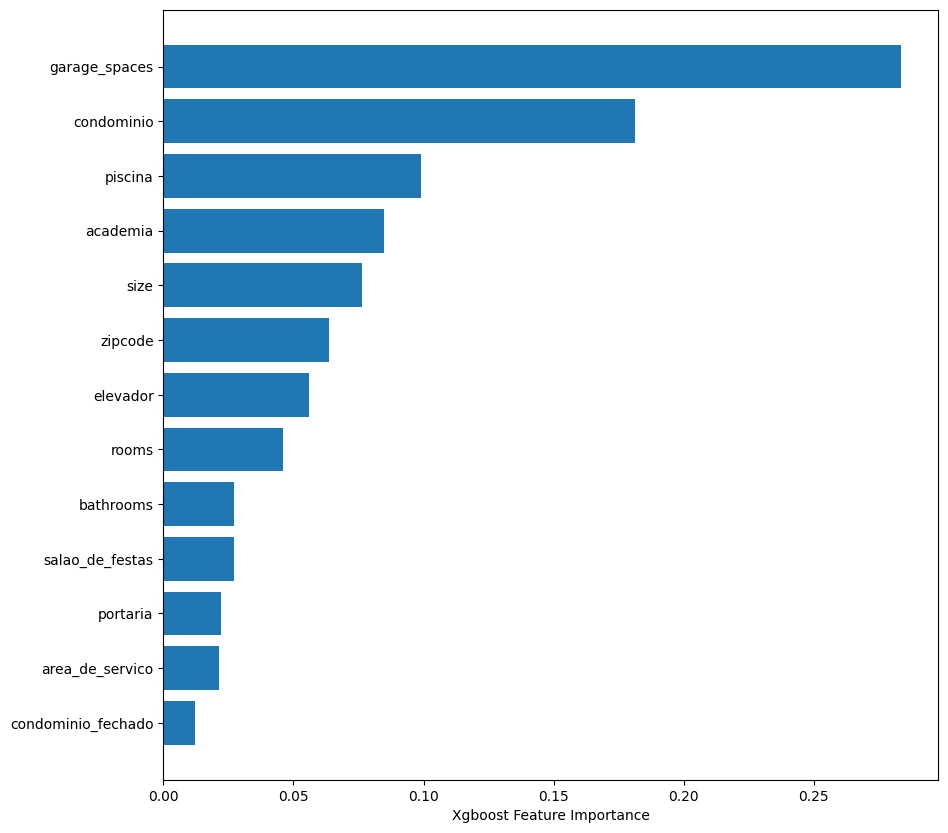

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
sorted_idx = model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx])#max_num_features=50, height=0.8

plt.xlabel("Xgboost Feature Importance")

# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Hypertuning</p></div> 

# Optuna

In [11]:
def objective(trial):
    param = {
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'sampling_method': 'gradient_based',
        'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
        'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
        'eta': trial.suggest_categorical('eta', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'gamma': trial.suggest_categorical('gamma', [18, 19, 20, 21, 22, 23, 24, 25]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 8, 600),  
        'max_depth': trial.suggest_categorical('max_depth', [3, 4, 5, 6, 7]),  
        'subsample': trial.suggest_categorical('subsample', [0.5,0.6,0.7,0.8,1.0]),
        'random_state': 42
    }

    model = XGBRegressor(**param)
    
    
    #model.fit(X_trainval, y_trainval, eval_set=[(X_valid, y_valid)], early_stopping_rounds=10, verbose=False) 
    
    # se o modelo não melhorar em 10 interações vai parar
    #model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False) 
    model.fit(X_train, y_train) 
    
    predict = model.predict(X_val)

    mape = mean_absolute_percentage_error(np.expm1(y_val), np.expm1(predict))

    return mape

In [12]:
import time
start_time = time.time()

study = optuna.create_study(direction='minimize', 
                            sampler=TPESampler(seed=7),
                            pruner=HyperbandPruner(reduction_factor=3, min_resource=5))

#study.optimize(objective, n_trials=5000,  show_progress_bar=True,timeout=600 * 6, n_jobs=-1)
study.optimize(objective, n_trials=2,  show_progress_bar=True, n_jobs=-1)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


print("--- %s minutos ---" % ((time.time() - start_time) * 60))

  0%|          | 0/2 [00:00<?, ?it/s]

Number of finished trials: 2
Best trial:
  Value: 0.27997132172464806
  Params: 
    lambda: 11.39298979206004
    alpha: 14.316662307566206
    eta: 0.3
    gamma: 20
    learning_rate: 0.02
    colsample_bytree: 0.7
    colsample_bynode: 0.6
    n_estimators: 208
    min_child_weight: 308
    max_depth: 7
    subsample: 0.7
--- 55.97794532775879 minutos ---


In [13]:
fig = optuna.visualization.plot_slice(study)
fig.update_layout(template='plotly_dark', title='<b>Slice Plot', title_x=0.2)

In [14]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(template='plotly_dark', title='<b>Optimization History Plot', title_x=0.5)

In [15]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(template='plotly_dark', title='<b>Hyperparameter Importances', title_x=0.5)

In [16]:
# Plot slice plot
vis.plot_slice(study, params=["n_estimators", "max_depth"])

In [17]:
best_model = XGBRegressor(**study.best_params)
best_model.fit(X_train, y_train)


XGBRegressor(alpha=14.316662307566206, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=0.6,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eta=0.3, eval_metric=None,
             feature_types=None, gamma=20, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             lambda=11.39298979206004, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=308, missing=nan, monotone_constraints=None,
             n_estimators=208, n_jobs=None, ...)

In [18]:
print(f'Best model result in Test R2: {r2_score(y_val, best_model.predict(X_val))}')
print(f'Best model result in Train R2: {r2_score(y_train, best_model.predict(X_train))}')

Best model result in Test R2: 0.32724948187888436
Best model result in Train R2: 0.3239856078216544


In [19]:
# prediction
yhat_xgb = best_model.predict( X_val )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_val), np.expm1(yhat_xgb) )
xgb_result

,Model Name,MAE,MAPE,RMSE,R2
0,XGBoost Regressor,128037.12302,0.285562,167225.66741,0.050431


In [20]:
result_df = evaluate_model(best_model, X, np.expm1(y), kf)
result_df

,Model Name,MAE TRAIN,MAE TEST,MAPE TRAIN,MAPE TEST,RMSE TRAIN,RMSE TEST
0,XGBRegressor,81185.86 +/- 549.65,82370.33 +/- 1719.77,0.23 +/- 0.00,0.24 +/- 0.01,103319.89 +/- 685.40,104784.58 +/- 2059.22


Text(0.5, 0, 'Xgboost Feature Importance')

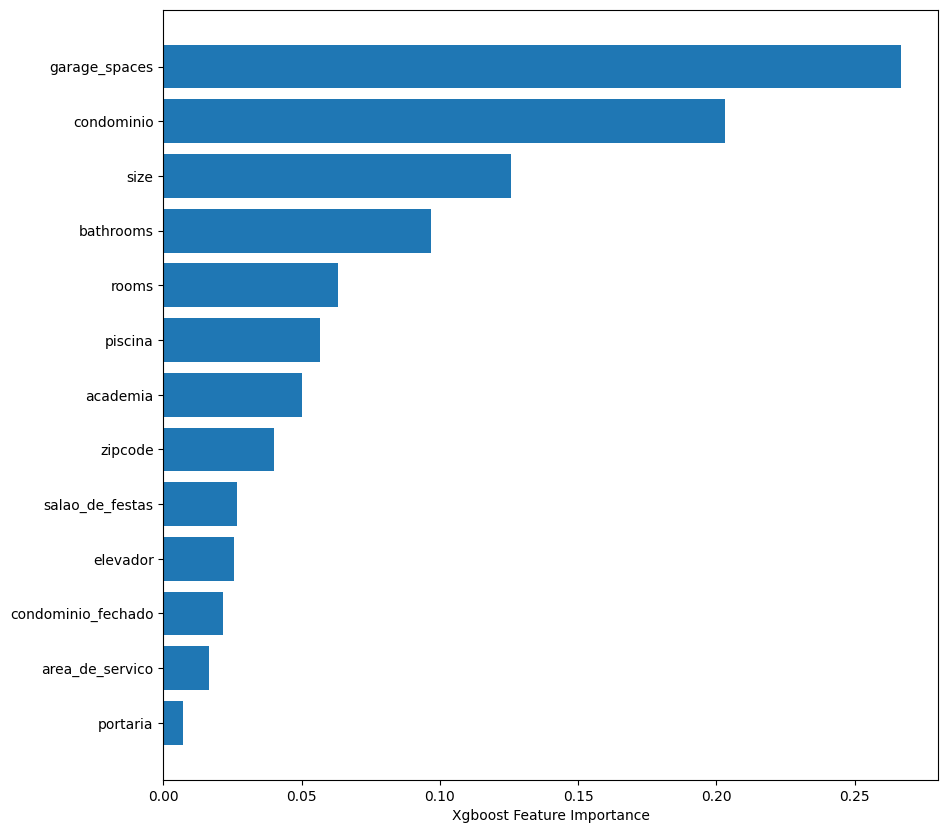

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
sorted_idx = best_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], best_model.feature_importances_[sorted_idx])#max_num_features=50, height=0.8

plt.xlabel("Xgboost Feature Importance")

# Random Search

In [22]:
# import random
# import pandas as pd
# import xgboost as xgb
# from sklearn.model_selection import cross_val_score

# # Define a seed aleatória para reproduzibilidade
# random.seed(42)

# param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
# }

# MAX_EVAL = 5
# final_result_list = []

# for _ in range(MAX_EVAL):
#     # Escolhe valores para os parâmetros aleatoriamente
#     hp = {k: random.choice(v) for k, v in param.items()}
#     print(hp)

#     # Criação do modelo XGBoost
#     model_xgb = xgb.XGBRegressor(
#         objective='reg:squarederror',
#         n_estimators=hp['n_estimators'],
#         eta=hp['eta'],
#         max_depth=hp['max_depth'],
#         subsample=hp['subsample'],
#         colsample_bytree=hp['colsample_bytree'],
#         min_child_weight=hp['min_child_weight']
#     )

#     # Avaliação de desempenho usando cross_val_score
#     scores = cross_val_score(model_xgb, X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')
#     mape_scores = -scores  # Convertendo de negativo para positivo

#     mean_mape = np.mean(mape_scores)
#     result = pd.DataFrame({
#         'n_estimators': [hp['n_estimators']],
#         'eta': [hp['eta']],
#         'max_depth': [hp['max_depth']],
#         'subsample': [hp['subsample']],
#         'colsample_bytree': [hp['colsample_bytree']],
#         'min_child_weight': [hp['min_child_weight']],
#         'mean_mape': [mean_mape]
#     })
#     final_result_list.append(result)


# # Concatenação dos resultados em um DataFrame final
# final_result = pd.concat(final_result_list, ignore_index=True)


In [23]:
# final_result

# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Produção</p></div> 

# PRE-PROD

# XGBoost

In [24]:
study.best_params

{'lambda': 11.39298979206004,
 'alpha': 14.316662307566206,
 'eta': 0.3,
 'gamma': 20,
 'learning_rate': 0.02,
 'colsample_bytree': 0.7,
 'colsample_bynode': 0.6,
 'n_estimators': 208,
 'min_child_weight': 308,
 'max_depth': 7,
 'subsample': 0.7}

In [25]:

model_prod_xgb = xgb.XGBRegressor(**study.best_params)  
kf = KFold(n_splits=5, shuffle=True, random_state=42)
result_df = evaluate_model(model_prod_xgb, X, np.expm1(y), kf)
result_df

,Model Name,MAE TRAIN,MAE TEST,MAPE TRAIN,MAPE TEST,RMSE TRAIN,RMSE TEST
0,XGBRegressor,81185.86 +/- 549.65,82370.33 +/- 1719.77,0.23 +/- 0.00,0.24 +/- 0.01,103319.89 +/- 685.40,104784.58 +/- 2059.22


# Ensemble

In [26]:
r1 = xgb.XGBRegressor(**study.best_params)
r2 = RandomForestRegressor()

model7 = VotingRegressor([('xgb', r1), ('RF', r2)])
model7.fit(X_train, y_train)
y_pred = model7.predict(X_val)

result = evaluate_model(model7, X, np.expm1(y), kf)
result

,Model Name,MAE TRAIN,MAE TEST,MAPE TRAIN,MAPE TEST,RMSE TRAIN,RMSE TEST
0,VotingRegressor,47684.34 +/- 246.64,60954.08 +/- 1216.24,0.14 +/- 0.00,0.18 +/- 0.00,61554.88 +/- 265.29,81205.50 +/- 1700.72


# PROD

In [27]:
r1 = xgb.XGBRegressor(**study.best_params)
r2 = RandomForestRegressor()

model_prod = VotingRegressor([('xgb', r1), ('RF', r2)])
model_prod.fit(X, y)

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(alpha=14.316662307566206,
                                          base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=0.6,
                                          colsample_bytree=0.7,
                                          early_stopping_rounds=None,
                                          enable_categorical=False, eta=0.3,
                                          eval_metric=None, feature_types=None,
                                          gamma=20, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          lambda=11.39298979206004,
                                          learning_rate=0.02, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=7,
                                          max_leaves=None, min_child_weight=308,
                                          missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=208, n_jobs=None, ...)),
                            ('RF', RandomForestRegressor())])

# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Feature Importance</p></div> 

# SHAP

In [28]:
explainer = shap.TreeExplainer(model_prod_xgb)
shap_values = explainer.shap_values(X_train)

In [29]:
features = SELECTED_FEATURES

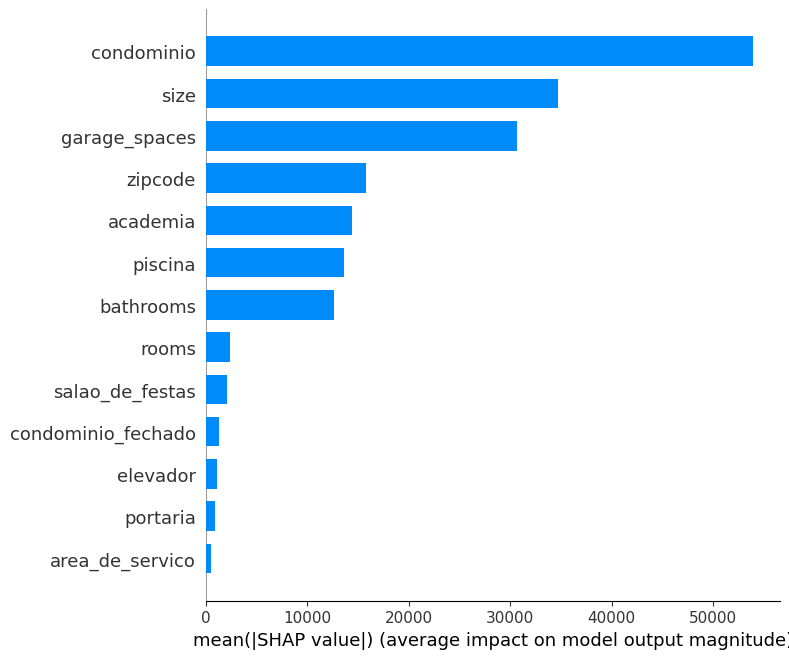

In [30]:
shap.summary_plot(shap_values, X_train, feature_names=features, plot_type="bar")

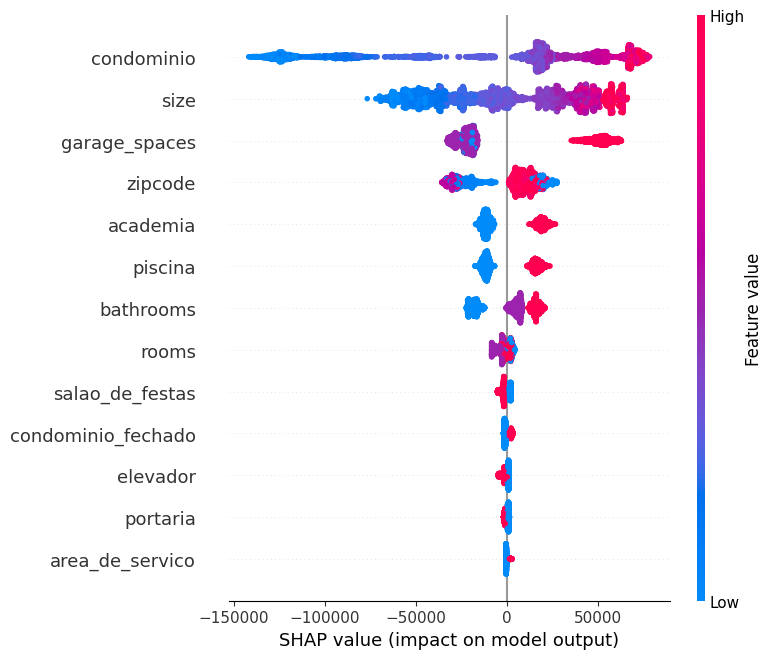

In [31]:
shap.summary_plot(shap_values, X_train, feature_names=features)

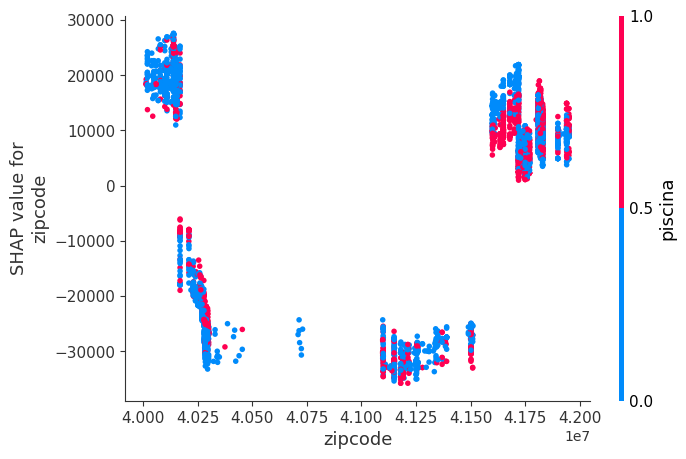

In [32]:
shap.dependence_plot(5, shap_values, X_train, feature_names=features)

# Error Translation and Interpretarion

In [33]:

df9 = pd.concat([X_val, y_val], axis=1)
# rescale
df9['price'] = np.expm1( df9['price'] )
df9['predictions'] = np.expm1( y_pred )

In [34]:
# sum of predictions
df91 = df9[['zipcode', 'predictions']].groupby( 'zipcode' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['zipcode', 'price', 'predictions']].groupby( 'zipcode' ).apply( lambda x: mean_absolute_error( x['price'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['zipcode', 'price', 'predictions']].groupby( 'zipcode' ).apply( lambda x: mean_absolute_percentage_error( x['price'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='zipcode' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='zipcode' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['zipcode', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [35]:
df92.sort_values( 'MAPE', ascending=False ).head()

,zipcode,predictions,worst_scenario,best_scenario,MAE,MAPE
7,40040180,185511.441855,60000.0,311022.883711,125511.441855,2.091857
231,41412265,151637.998894,50000.0,253275.997788,101637.998894,2.032760
162,40490212,171112.857618,60000.0,282225.715235,111112.857618,1.851881
5,40025000,127267.025627,60000.0,194534.051255,67267.025627,1.121117
224,41341650,132218.306404,65000.0,199436.612808,67218.306404,1.034128


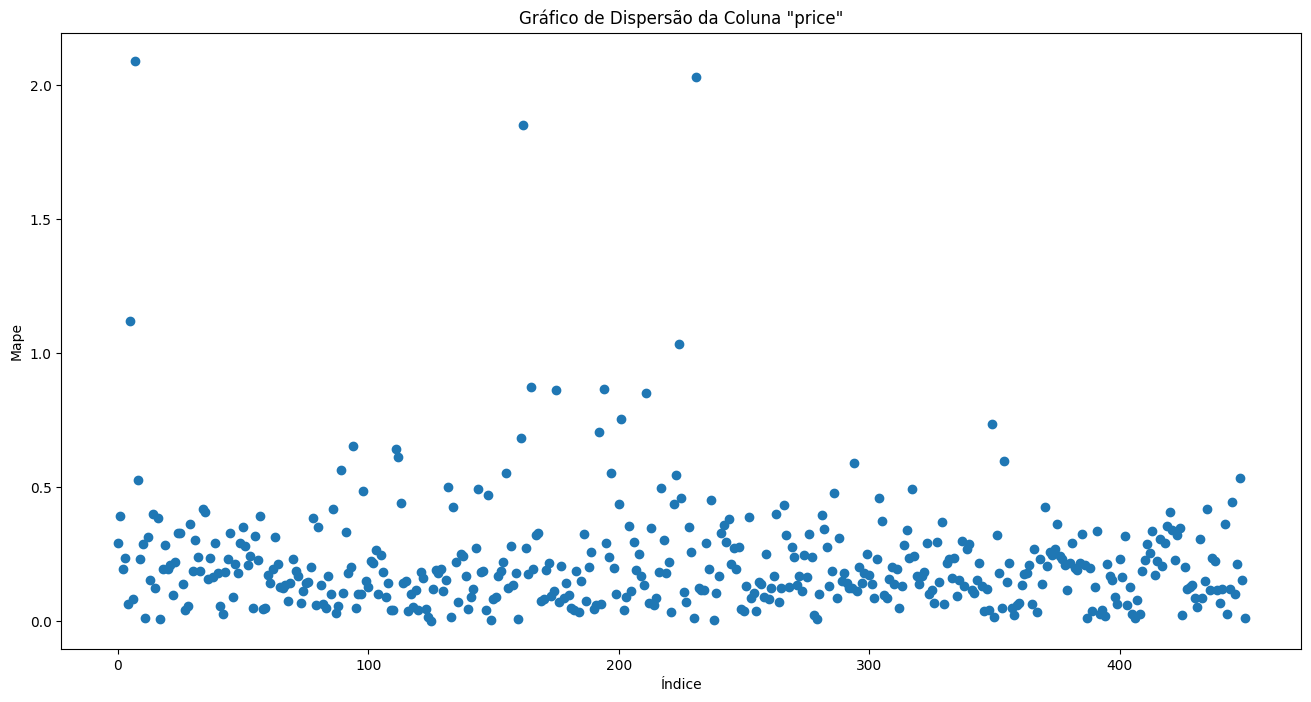

In [36]:
# mostra pela quantdade de linhas do meu data set como ta espalhado o price 
prices = df92['MAPE']
plt.figure(figsize=(16, 8))
plt.scatter(range(len(prices)), prices)
plt.title('Gráfico de Dispersão da Coluna "price"')
plt.xlabel('Índice')
plt.ylabel('Mape')
plt.show()

# DEPLOY MODEL TO PRODUCTION

In [37]:
pickle.dump( model_prod, open( '../models/model_olx.pkl', 'wb' ) )